In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import random
from torch import nn, optim
import scanpy as sc
import scvelo as scv
from anndata import AnnData
import torch.utils.data as data
from torch.nn import functional as F
from scipy.stats import truncnorm
from scipy.sparse import issparse
from sklearn.decomposition import PCA
from scvelo.core import invert, SplicingDynamics
from scvelo.tools.utils import make_dense
from scvelo.plotting.simulation  import compute_dynamics
from scvelo.tools._em_model_utils import get_vars, tau_inv, unspliced, vectorize



In [25]:
adata_scvelo = sc.read_h5ad('./data/adata_scvelo.h5ad')
adata_true = sc.read_h5ad('./data/adata_true.h5ad')
adata_init = sc.read_h5ad('./data/adata_init.h5ad')
adata_velotrace = sc.read_h5ad('./data/adata_velotrace.h5ad')


In [22]:
scv.tl.recover_dynamics(adata_velotrace)
scv.tl.velocity(adata_velotrace, mode='dynamical')


recovering dynamics (using 1/128 cores)


  0%|          | 0/60 [00:00<?, ?gene/s]

    finished (0:00:05) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [15]:
def write_fit_layers_from_pars(adata):
    to_dense = lambda x: x.A if hasattr(x, "A") else np.asarray(x)
    if "fit_t" not in adata.layers:
        raise KeyError("缺少 adata.layers['fit_t']，请先运行 recover_dynamics。")
    fit_t = to_dense(adata.layers["fit_t"])
    n_cells, n_genes = fit_t.shape

    fit_u = np.full((n_cells, n_genes), np.nan, dtype=np.float32)
    fit_s = np.full_like(fit_u, np.nan)

    has_scaling = "fit_scaling" in adata.var
    has_u0 = "fit_u0" in adata.var
    has_s0 = "fit_s0" in adata.var

    for g, gene in enumerate(adata.var_names):
        sub = adata[:, gene]
        alpha_i, beta_i, gamma_i, scaling_i, t_switch = get_vars(sub, key="fit")
        alpha_i = float(np.atleast_1d(alpha_i)[0])
        beta_i = float(np.atleast_1d(beta_i)[0])
        gamma_i = float(np.atleast_1d(gamma_i)[0])
        scaling_i = float(np.atleast_1d(scaling_i)[0]) if has_scaling else 1.0
        t_switch = float(np.atleast_1d(t_switch)[0])

        u0_off = float(adata.var["fit_u0"].iat[g]) if has_u0 else 0.0
        s0_off = float(adata.var["fit_s0"].iat[g]) if has_s0 else 0.0

        t_vec = fit_t[:, g]
        if np.all(~np.isfinite(t_vec)):
            continue

        tau, alpha_vec, u0_vec, s0_vec = vectorize(
            t_vec, t_switch, alpha_i, beta_i, gamma_i,
            alpha_=0.0, u0=0.0, s0=0.0, sorted=False
        )
        ut, st = SplicingDynamics(
            alpha=alpha_vec, beta=beta_i, gamma=gamma_i,
            initial_state=[u0_vec, s0_vec]
        ).get_solution(tau, stacked=False)

        fit_u[:, g] = ut * scaling_i + u0_off
        fit_s[:, g] = st + s0_off

    adata.layers["fit_u"] = fit_u
    adata.layers["fit_s"] = fit_s
    
write_fit_layers_from_pars(adata_velotrace)

/home/yuyang/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
def align_gene_and_cell_time(adata):
    """
    将细胞按照 pseudotime 排序后，对每个基因的时间（fit_t）进行排序，
    并同步调整 fit_u 和 fit_s。

    参数:
        adata (AnnData): 包含 pseudotime 和 fit_t/fit_u/fit_s 的 AnnData 对象。

    返回:
        AnnData: 经过重新排列后的 AnnData 对象。
    """
    # 确保 pseudotime 存在
    if 'velocity_pseudotime' not in adata.obs:
        raise ValueError("adata.obs 中缺少 'velocity_pseudotime' 列。")

    # 确保 fit_t 存在
    if 'fit_t' not in adata.layers:
        raise ValueError("adata.layers 中缺少 'fit_t' 层。")

    # 将 pseudotime 转换为 numpy 数组
    pseudotime = adata.obs['velocity_pseudotime'].to_numpy()

    # 将细胞按照 pseudotime 排序
    sorted_cell_indices = np.argsort(pseudotime)
    adata = adata[sorted_cell_indices].copy()

    # 获取 fit_t, fit_u, fit_s
    fit_t = adata.layers['fit_t']
    fit_u = adata.layers['fit_u']
    fit_s = adata.layers['fit_s']

    # 转换为稠密矩阵（如果是稀疏矩阵）
    fit_t = fit_t.A if issparse(fit_t) else np.asarray(fit_t)
    fit_u = fit_u.A if issparse(fit_u) else np.asarray(fit_u)
    fit_s = fit_s.A if issparse(fit_s) else np.asarray(fit_s)

    # 初始化新的 fit_u 和 fit_s
    aligned_fit_u = np.zeros_like(fit_u)
    aligned_fit_s = np.zeros_like(fit_s)

    # 对每个基因（列）按照 fit_t 排序
    for gene_idx in range(fit_t.shape[1]):
        # 获取当前基因的时间排序索引
        sorted_time_indices = np.argsort(fit_t[:, gene_idx])

        # 按照时间排序 fit_u 和 fit_s
        aligned_fit_u[:, gene_idx] = fit_u[sorted_time_indices, gene_idx]
        aligned_fit_s[:, gene_idx] = fit_s[sorted_time_indices, gene_idx]

    # 将重新排列的结果写回 adata
    adata.layers['fit_u_aligned'] = aligned_fit_u
    adata.layers['fit_s_aligned'] = aligned_fit_s

    return adata
adata_velotrace = align_gene_and_cell_time(adata_velotrace)

/home/yuyang/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/yuyang/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


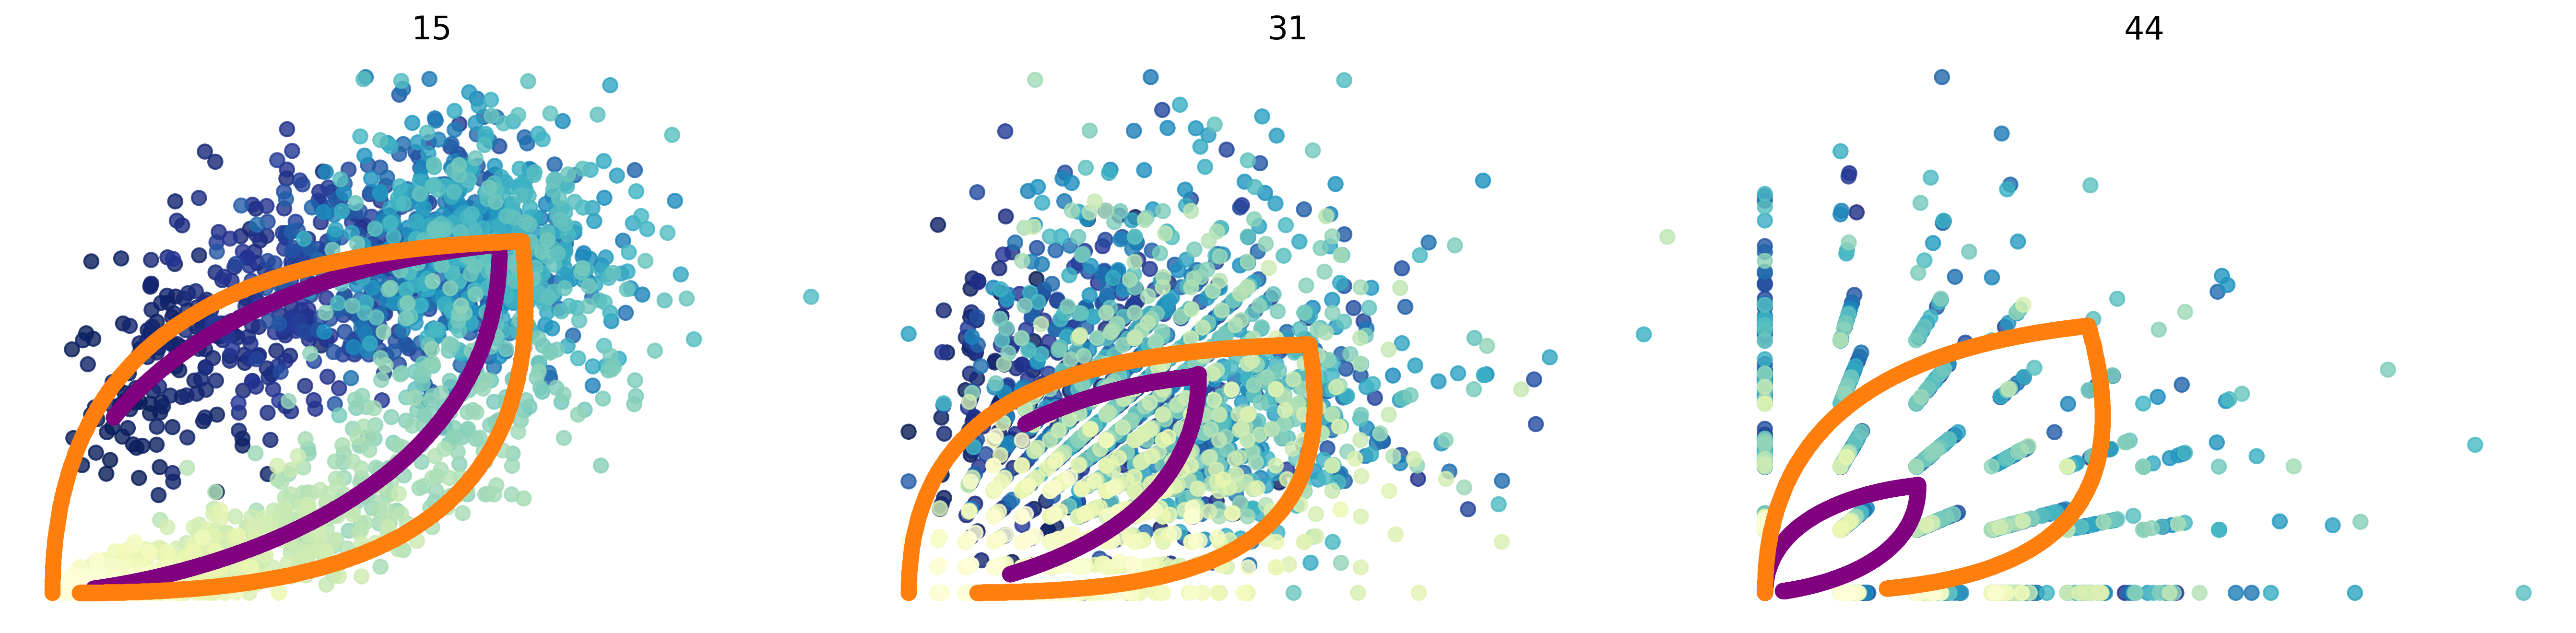

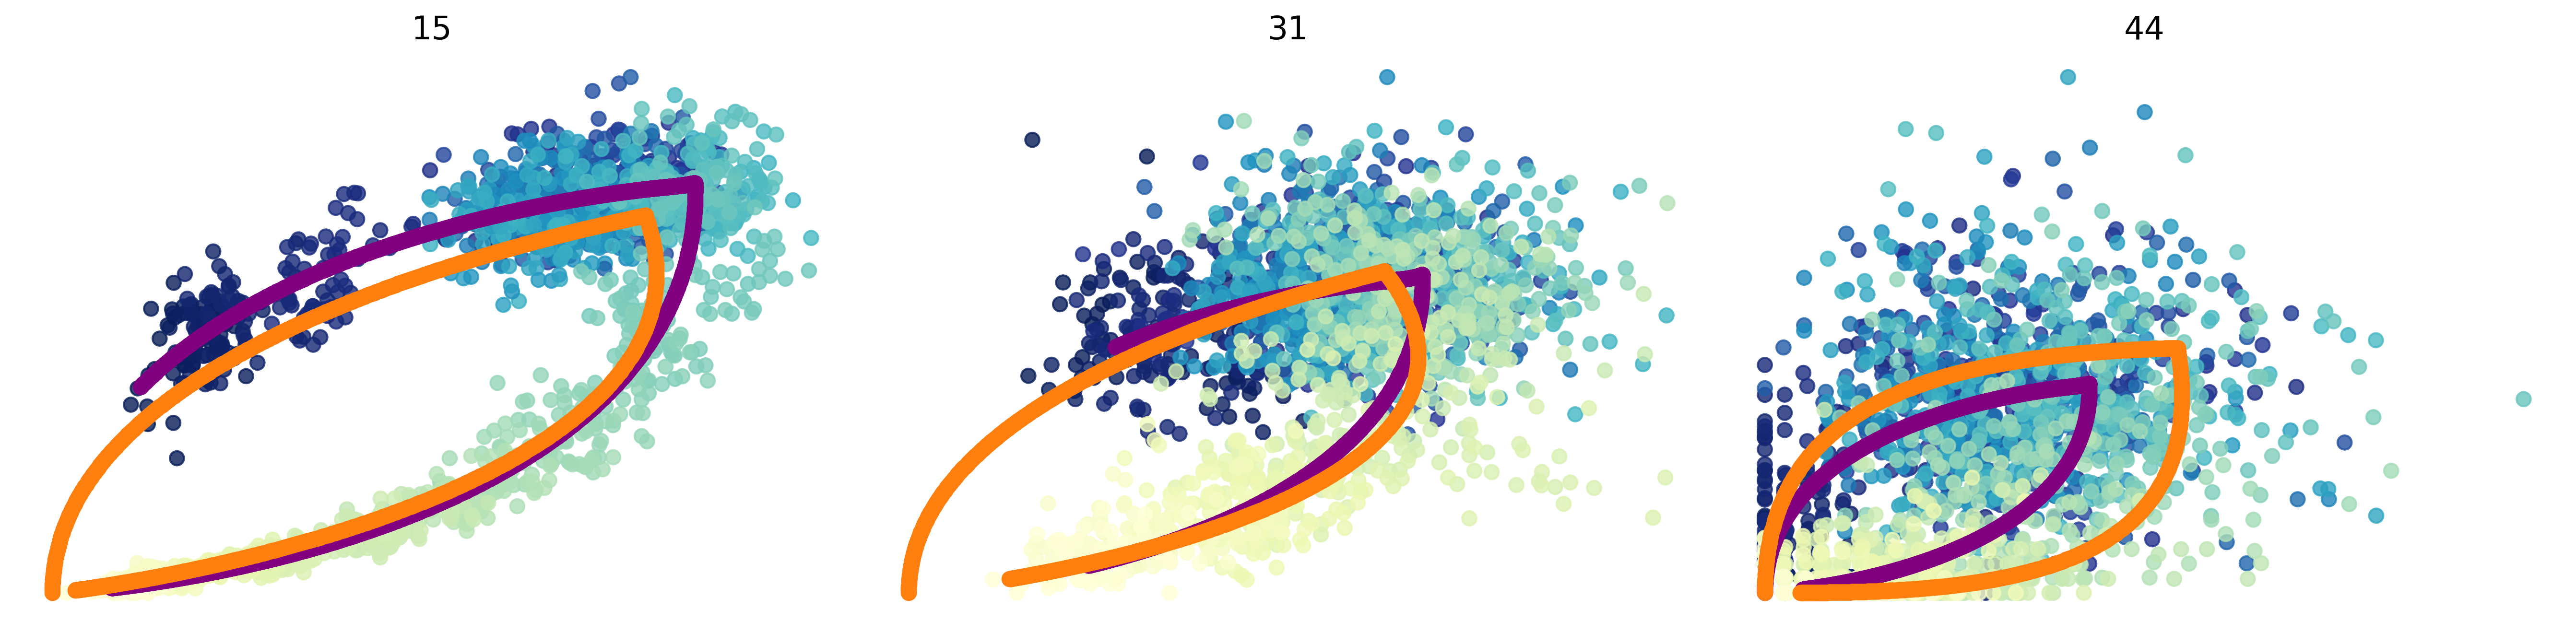

In [24]:
style_kwargs = {
    'fontsize': 18, 
    'linewidth': 6, 
    'frameon': False, 
    'alpha': 0.8  
}

def compare_circle_with_gt_styled(adata, adata_true, basis, key='fit', save_path=None, **kwargs):
    fig, ax = plt.subplots(1, len(basis), figsize=(6*len(basis), 4.5), dpi=300)
    
    col_true = 'purple' 
    col_fit = '#ff7f0e' 
    
    linewidth = kwargs.get('linewidth', 6)

    for i in range(len(basis)):
        gene_idx = basis[i]
        gene_name = adata.var_names[gene_idx] if hasattr(adata, 'var_names') else str(gene_idx)

        x_obs = make_dense(adata.layers['spliced'][:, gene_idx]).flatten()
        y_obs = make_dense(adata.layers['unspliced'][:, gene_idx]).flatten()
        

        ax[i].scatter(x_obs, y_obs, c=adata.obs["true_t"],cmap='YlGnBu_r', alpha=0.8, s=200, marker='.', label='Observed')

        x_true = make_dense(adata_true.layers['spliced'][:, gene_idx]).flatten()
        y_true = make_dense(adata_true.layers['unspliced'][:, gene_idx]).flatten()
        
        ax[i].scatter(x_true, y_true, color=col_true, s=50, alpha=1, label='Ground Truth', zorder=2)


        _, ut, st = compute_dynamics(adata, basis=gene_idx, key=key, sort=True, extrapolate=True)
        ax[i].scatter(st, ut, color=col_fit, s=50, label='Learned Dynamics', zorder=3)
        
        ax[i].set_title(f'{gene_name}', fontsize=16)
        
        ax[i].axis('off')

        
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight', format='svg')
    plt.tight_layout()
    plt.show()


compare_circle_with_gt_styled(adata_scvelo, adata_true, basis=[15, 31, 44])
compare_circle_with_gt_styled(adata_velotrace, adata_true, basis=[15,31,44])